In [25]:
stop_words = ['Vote', 'Country', 'Name', 'First (5 points)', 'Second (3 points)', 'Third (1 point)']

In [45]:
def get_values_for(f, curr_word):
    processing_active = False
    for line in f:
        line = line.strip()
        if line.startswith(curr_word):
            processing_active = True
            continue

        if line=='':            
            processing_active = False
            continue
        
        if '/' in line:
            continue

        if processing_active:
            yield line
        

In [48]:
fname = './fwd.txt'
f = open(fname, 'r')

data = dict()
for word in stop_words:
    f.seek(0)
    data[word] = list(get_values_for(f, word))


In [49]:
for k, v in data.items():
    print('{} --> {}'.format(k, len(v)))

Vote --> 459
Country --> 459
Name --> 459
First (5 points) --> 459
Second (3 points) --> 459
Third (1 point) --> 459


In [1]:
import pandas as pd

In [57]:
df = pd.DataFrame.from_dict(data, orient='columns')

In [66]:
df.rename(columns={'First (5 points)': 'First', 'Second (3 points)': 'Second', 'Third (1 point)': 'Third'}, inplace=True)

In [69]:
df =df[['Vote', 'Country', 'Name', 'First', 'Second', 'Thirds']]

In [12]:
df.Vote.value_counts()

Media      156
Coach      152
Captain    151
Name: Vote, dtype: int64

In [227]:
df.to_csv('./player-votes.csv')

In [2]:
df = pd.read_csv('./player-votes.csv', index_col=0)

In [3]:
df.First.value_counts()

Cristiano Ronaldo            340
Messi Lionel                  55
Neymar                        15
Buffon Gianluigi               8
Kroos Toni                     7
Aubameyang Pierre-Emerick      6
Ramos Sergio                   6
Modric Luka                    5
Suárez Luis                    4
Kanté N'Golo                   3
Navas Keylor                   2
Neuer Manuel                   2
Lewandowski Robert             2
Ibrahimovic Zlatan             2
Hazard Eden                    1
Kane Harry                     1
Name: First, dtype: int64

In [4]:
# Votes without Ronaldo and Messi
no_ronaldo = df[df.apply(lambda x: 'Cristiano Ronaldo' not in [x['First'], x['Second'], x['Third']], axis='columns')]
no_messi = df[df.apply(lambda x: 'Messi Lionel' not in [x['First'], x['Second'], x['Third']], axis='columns')]

print('{}% of votes did not include Ronaldo'.format(100*len(no_ronaldo)/len(df)))
print('{}% of votes did not include Messi'.format(100*len(no_messi)/len(df)))


9.803921568627452% of votes did not include Ronaldo
36.60130718954248% of votes did not include Messi


In [84]:
# pivoting the table to get summaries by player
def pivot_it(df):
    nf = pd.DataFrame(df.First.value_counts())
    nf2 = pd.DataFrame(df.Second.value_counts())
    nf3 = pd.DataFrame(df.Third.value_counts())

    res = nf.join((nf2.join(nf3, how='outer')), how='outer')
    # for some reason some columns are float and not int
    res.fillna(0.0, inplace=True)
    return res.astype(int)

def add_points(df):
    # calculate number of votes and points according to FIFA rules (first == 5 pts, second = 3 pts, third = 1pt)
    res = df.copy()
    res['Occurances'] = df.First + df.Second + df.Third
    res['Points'] = df.First * 5 + df.Second * 3 + df.Third
    all_points = res.Points.sum()
    res['RelativePoints'] = res['Points'] / all_points
    return res

def get_results_for(df):
    return add_points(pivot_it(df))

In [69]:
# who would win in each group (i.e. Couches, Playes, Media)

for role in df.Vote.unique():
    tmp_table = df.loc[df.Vote==role]
    tmp_table = get_results_for(tmp_table)
    print('\nResults for role {}'.format(role))
    print(tmp_table.Points.sort_values(ascending=False).head(4))



Results for role Captain
Cristiano Ronaldo    605
Messi Lionel         255
Neymar               114
Buffon Gianluigi      83
Name: Points, dtype: int64

Results for role Coach
Cristiano Ronaldo    586
Messi Lionel         301
Neymar               108
Buffon Gianluigi      80
Name: Points, dtype: int64

Results for role Media
Cristiano Ronaldo    697
Messi Lionel         267
Buffon Gianluigi     154
Neymar                76
Name: Points, dtype: int64


In [22]:
# top 10 with most points
res.Points.sort_values(ascending=False).head(10)

Cristiano Ronaldo            1888
Messi Lionel                  823
Buffon Gianluigi              317
Neymar                        298
Ramos Sergio                  126
Modric Luka                   115
Kroos Toni                     76
Kanté N'Golo                   63
Aubameyang Pierre-Emerick      56
Hazard Eden                    42
Name: Points, dtype: int64

In [224]:
# top 10 least popular players
res.Occurances.sort_values().head(10)

Carvajal Dani          3
Navas Keylor           6
Kane Harry             7
Neuer Manuel           8
Vidal Arturo           9
Griezmann Antoine      9
Sanchez Alexis        10
Iniesta Andrés        11
Bonucci Leonardo      12
Ibrahimovic Zlatan    13
Name: Occurances, dtype: int64

In [74]:
url2 = 'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv'

country_region = pd.read_csv(url2)
country_region = country_region[['name', 'region', 'sub-region']]
country_region.rename(columns={'name':'Country', 'region':'Region', 'sub-region': 'Sub-Region'}, inplace=True)
country_region.set_index('Country', inplace=True)

In [75]:

df_extend = df.join(country_region, on='Country', how='left')

In [76]:
df_extend.head()

,Vote,Country,Name,First,Second,Third,Region,Sub-Region
0,Captain,Albania,Agolli Ansi,Cristiano Ronaldo,Messi Lionel,Buffon Gianluigi,Europe,Southern Europe
1,Captain,Algeria,Mbolhi Adi Rais,Cristiano Ronaldo,Buffon Gianluigi,Messi Lionel,Africa,Northern Africa
2,Captain,American Samoa,Ott Ramin,Cristiano Ronaldo,Neymar,Dybala Paulo,Oceania,Polynesia
3,Captain,Andorra,Lima Sola Ildefons,Neymar,Modric Luka,Buffon Gianluigi,Europe,Southern Europe
4,Captain,Angola,Gaspar Wilson Pinto,Cristiano Ronaldo,Ramos Sergio,Modric Luka,Africa,Middle Africa


In [85]:
for reg in df_extend.Region.unique():
    print('\nRegion: {}'.format(reg))
    print(get_results_for(df_extend.loc[df_extend.Region==reg]).sort_values(by='Points', ascending=False).head(3))


Region: Europe
                   First  Second  Third  Occurances  Points  RelativePoints
Cristiano Ronaldo     84      12      4         100     460        0.460460
Messi Lionel           9      33     17          59     161        0.161161
Buffon Gianluigi       1      20     25          46      90        0.090090

Region: Africa
                   First  Second  Third  Occurances  Points  RelativePoints
Cristiano Ronaldo     70      10      3          83     383        0.467643
Messi Lionel          12      35     16          63     181        0.221001
Neymar                 5       9     13          27      65        0.079365

Region: Oceania
                   First  Second  Third  Occurances  Points  RelativePoints
Cristiano Ronaldo     12       6      2          20      80        0.423280
Messi Lionel           5       7      2          14      48        0.253968
Neymar                 1       4      5          10      22        0.116402

Region: Americas
                   Fi

In [86]:
%matplotlib inline

In [87]:
from matplotlib.pyplot import pie, axis, show

In [88]:
rela = get_results_for(df)

In [89]:
rela.head()

,First,Second,Third,Occurances,Points,RelativePoints
Aubameyang Pierre-Emerick,6,4,14,24,56,0.013556
Bonucci Leonardo,0,4,8,12,20,0.004841
Buffon Gianluigi,8,66,79,153,317,0.076737
Carvajal Dani,0,3,0,3,9,0.002179
Cristiano Ronaldo,340,57,17,414,1888,0.457032


(-1.1208638231121117,
 1.1009935239109971,
 -1.1247398924765113,
 1.1036525038920384)

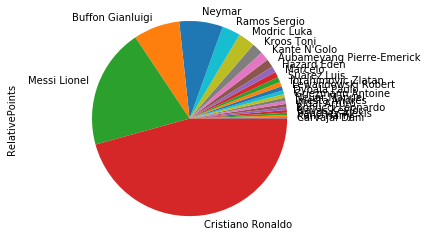

In [99]:
p = rela.RelativePoints.sort_values().plot(kind='pie')
axis('equal')

In [102]:
dta = rela.RelativePoints.sort_values(ascending=False)

In [114]:
others = 1.0 - dta.head(10).sum()

In [115]:
to_vis = dta.head(10)
to_vis['others'] = others

(-1.1208638251609488,
 1.1009935195544025,
 -1.1036525048265484,
 1.1247398888176334)

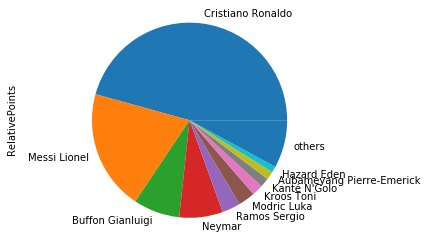

In [117]:
to_vis.plot(kind='pie')
axis('equal')

In [118]:
def generate_pie_plot(df, how_many = 8):
    dta = rela.RelativePoints.sort_values(ascending=False)
    others = 1.0 - dta.head(how_many).sum()
    to_vis = dta.head(how_many)
    to_vis['others'] = others
    return to_vis

In [121]:
vis = generate_pie_plot(rela, 5)

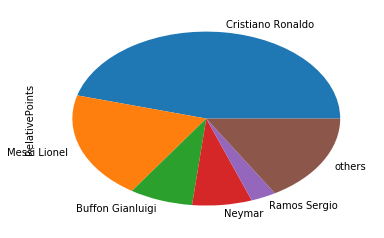

In [122]:
vis.plot(kind='pie')

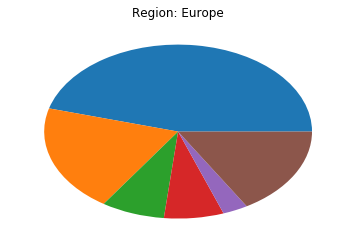

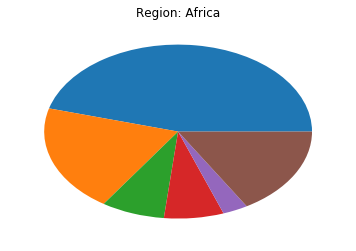

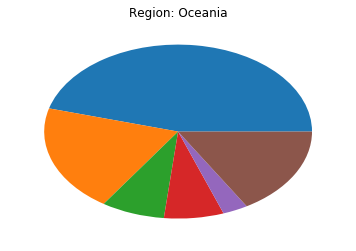

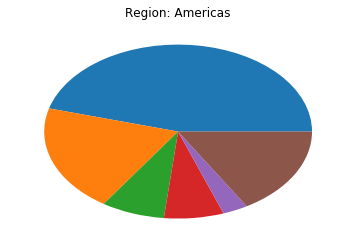

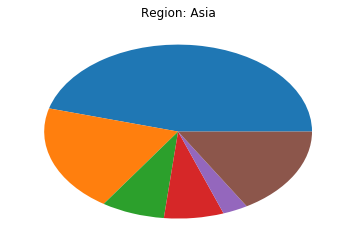

In [127]:
import matplotlib.pyplot as plt

i = 0;
for reg in df_extend.Region.unique()[:-1]:
    plt.figure(i)
    i+=1    
    res = get_results_for(df_extend.loc[df_extend.Region==reg]).sort_values(by='Points', ascending=False).head(3)
    vis = generate_pie_plot(res, 5)
    plt.pie(vis)
    plt.title('Region: {}'.format(reg))
    
    
plt.show()